<a href="https://colab.research.google.com/github/june1st/GoogleColab/blob/master/QuaternionMatrixConversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyquaternion

  Using cached https://files.pythonhosted.org/packages/73/87/9062e094c3aef59d08a0e8f5bdedc6085f6658ac38421a9808214c3138bb/pyquaternion-0.9.2.tar.gz
  Running setup.py bdist_wheel for pyquaternion ... - done
  Stored in directory: /root/.cache/pip/wheels/ce/3e/b2/0b3a4c2b9eb827981266c78cd39517a39efa6db43e3fb2e94d
Successfully built pyquaternion


In [0]:
#coding:utf-8
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import ctypes
from ctypes import * #c_double, c_int, c_float
import platform
import csv
from pyquaternion import Quaternion
#os.chdir(os.path.dirname(__file__))

class QuatCF:
    """相補フィルタクラス"""
    def __init__(self, Aa):
        """コンストラクタ（フィルタ係数A≒0.9を設定）"""
        self.A = Aa
        self.q = Quaternion(1, 0, 0 ,0)

    def update(self,qa, qg):
        """相補フィルタの更新"""
        self.q = self.A * qg *self.q + (1-self.A)*qa


def makeQa(ax, ay, az):
    """加速度センサの姿勢を表す回転子"""
    accNorm = np.sqrt(ax**2 + ay**2 + az**2)	# 加速度ノルムの逆数
    ax /= accNorm
    ay /= accNorm
    az /= accNorm
    # 回転軸の生成（資料では回転軸の正規化を忘れているので注意 ： n ＝ n/|n|にしないといけない）
    square = ax**2 + ay**2;
    rotateNorm = 1;
    if (square > 0.00001):
         rotateNorm = np.sqrt(square);
    nx = ax / rotateNorm;
    ny = ay / rotateNorm;
    theta_a = 0.5*np.arccos(az);
    qa = Quaternion( np.cos(theta_a), ny*np.sin(theta_a), -nx*np.sin(theta_a), 0 )
    return qa.normalised

def makeQg(gx, gy, gz):
    """ジャイロセンサの姿勢変化を表す回転子"""
    dt = 0.040                  # [ms]
    calib = 0.0001527163     # sensor calibration
    a = 0.5 * dt;
    ggx = a * gx * calib;
    ggy = a * gy * calib;
    ggz = a * gz * calib;
    s = 1.0 - 0.5 * (ggx **2 + ggy **2 + ggz **2)
    qg = Quaternion(s, ggx, ggy, ggz)
    return qg.normalised

def makeMatrixFromAM(ax, ay, az, mx, my, mz):
    """加速度，地磁気センサから回転行列生成"""
    ret = np.identity(3)
    aNorm = np.sqrt(ax**2+ay**2+az**2 )
    mNorm = np.sqrt(mx**2+my**2+mz**2 )
    crossNorm = aNorm * mNorm
    ret[0][0] = (my*az - mz*ay) / crossNorm
    ret[0][1] = (mz*ax - mx*az) / crossNorm
    ret[0][2] = (mx*ay - my*ax) / crossNorm
    ret[1][0] = mx / mNorm
    ret[1][1] = my / mNorm
    ret[1][2] = mz / mNorm
    ret[2][0] = ax / aNorm
    ret[2][1] = ay / aNorm
    ret[2][2] = az / aNorm
    return ret

def MatrixToQuaternion(mat):
    """回転行列をクォータニオンにする"""
    q = Quaternion()
    tr = mat[0][0] + mat[1][1] + mat[2][2] + 1.0;
    print(tr)
    if (tr >= 1.0) :
        s = 0.5 / np.sqrt(tr);
        q.w= 0.25 / s;
        q.x= (mat[1][2] - mat[2][1]) * s;
        q.y= (mat[2][0] - mat[0][2]) * s;
        q.z= (mat[0][1] - mat[1][0]) * s;
        q = Quaternion(q.w, q.x, q.y, q.z)
        return q
    else:
        if(mat[1][1] > mat[2][2]):
            max = mat[1][1];
        else:
            max = mat[2][2];

    if (max < mat[0][0]) :
        s = np.sqrt(mat[0][0] - (mat[1][1] + mat[2][2]) + 1.0);
        x = s * 0.5;
        s = 0.5 / s;
        q.x= x;
        q.y= (mat[0][1] + mat[1][0]) * s;
        q.z= (mat[2][0] + mat[0][2]) * s;
        q.w= (mat[1][2] - mat[2][1]) * s;
        q = Quaternion(q.w, q.x, q.y, q.z)
        return q;
    elif (max == mat[1][1]):
        s = np.sqrt(mat[1][1] - (mat[2][2] + mat[0][0]) + 1.0);
        y = s * 0.5;
        s = 0.5 / s;
        q.x= (mat[0][1] + mat[1][0]) * s;
        q.y= y;
        q.z= (mat[1][2] + mat[2][1]) * s
        q.w= (mat[2][0] - mat[0][2]) * s;
        q = Quaternion(q.w, q.x, q.y, q.z)
        return q;
    else:
        s = np.sqrt(mat[2][2] - (mat[0][0] + mat[1][1]) + 1.0);
        z = s * 0.5;
        s = 0.5 / s;
        q.x= (mat[2][0] + mat[0][2]) * s;
        q.y= (mat[1][2] + mat[2][1]) * s;
        q.z= z;
        q.w= (mat[0][1] - mat[1][0]) * s;
        q = Quaternion(q.w, q.x, q.y, q.z)
        return q;

def unwrap(old ,new ):
    if old-new >3.14:
        new += 6.28
    if old-new < -3.14:
        new -= 6.28
    return new


In [0]:
qqq = Quaternion(axis = np.array([1,0,0]), angle =np.pi/2);
qqq = qqq * qqq * qqq * qqq
print qqq.rotation_matrix
mat = qqq.rotation_matrix
print mat[0][0]
print Quaternion(matrix = qqq.rotation_matrix)

print 'Calculated Q from sensor values'
print makeQa(0, -1, 1)
q = Quaternion(axis = np.array([-1,0,0]), angle = np.radians(45));
print 'Designed Q'
print q
print 'reconstructed Q from matrix'
print MatrixToQuaternion(q.rotation_matrix)

print 'Forward bending 45defg'
print 'from Sensor'
print  makeMatrixFromAM(0, -0.707, 0.707, 0, 0.707, 0.707)
print 'Desired value'
q = Quaternion(axis = np.array([-1,0,0]), angle = np.radians(45));
print q.rotation_matrix

print 'Rotation 45defg'
print 'from Sensor'
print  makeMatrixFromAM(0, 0, 1, 0.707, 0.707, 0)
q = Quaternion(axis = np.array([0,0,1]), angle = np.radians(45));
print 'Desired value'
print q.rotation_matrix
print q.elements


In [66]:
q = Quaternion(axis = np.array([0,1,0]), angle =np.pi/4);
print(q)
m= [0,1,0]
a= [1,0,1]
#m = [0.707, 0,707,0]
M=makeMatrixFromAM(a[0],a[1],a[2], m[0],m[1],m[2])
qq = MatrixToQuaternion(M)
print(M)
print(qq)

0.924 +0.000i +0.383j +0.000k
3.414213562373095
[[ 0.70710678  0.         -0.70710678]
 [ 0.          1.          0.        ]
 [ 0.70710678  0.          0.70710678]]
0.924 +0.000i +0.383j +0.000k


In [61]:
import numpy as mp
print(np.arccos(0.92387953)*57*2)
print(np.arcsin(0.38268343)*57*2)

44.76769606175772
44.76769502181972


In [0]:
import matplotlib.pyplot as plt
#matplotlib inline

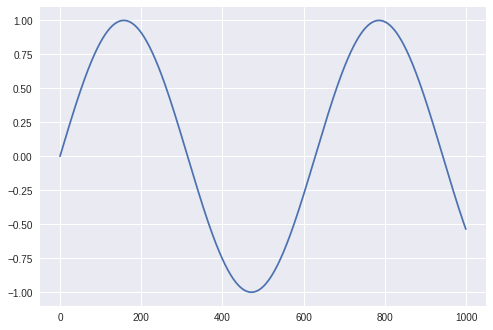

In [6]:
x = np.array(range(1000) )* 0.01
y=np.sin(x)
plt.plot(y)